## Downloading Dependencies

In [1]:
# First, we need to install pycocotools. This library will be used for computing the evaluation metrics following the COCO metric for intersection over union.
# The version by default in Colab has a bug fixed in https://github.com/cocodataset/cocoapi/pull/354
!pip install cython
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-v1g9w2oj
  Running command git clone -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-v1g9w2oj
  Created wheel for pycocotools: filename=pycocotools-2.0-cp37-cp37m-linux_x86_64.whl size=263901 sha256=e2a9d5553bab458eb71155191eca6bf11620f3ffe7f96efaa452971d7f3b8239
  Stored in directory: /tmp/pip-ephem-wheel-cache-1ycix0ih/wheels/90/51/41/646daf401c3bc408ff10de34ec76587a9b3ebfac8d21ca5c3a
Successfully built pycocotools
  Found existing installation: pycocotools 2.0.2
    Uninstalling pycocotools-2.0.2:
      Successfully uninstalled pycocotools-2.0.2


In [2]:
import json
import math
import os
import random
import sys
import time

import numpy as np
import torch
import torch.utils.data
import torchvision

from PIL import Image, ImageDraw
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
from torchvision import transforms
from torchvision.ops import batched_nms
from torchvision.transforms import functional as F

In [3]:
from typing import List, Tuple

import torchvision.models as models

from torchvision.models.detection.backbone_utils import resnet_fpn_backbone
from torchvision.models.detection.faster_rcnn import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.ops import MultiScaleRoIAlign

In `references/detection/,` we have a number of helper functions to simplify training and evaluating detection models.
Here, we will use `references/detection/utils.py` and `references/detection/coco_eval.py`.

Let's copy those files (and their dependencies) in here so that they are available in the notebook

In [4]:
%%shell

# Download TorchVision repo to use some files from references/detection
git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.3.0

cp references/detection/utils.py ../
cp references/detection/coco_eval.py ../

Cloning into 'vision'...
remote: Enumerating objects: 29023, done.
remote: Counting objects: 100% (1566/1566), done.
remote: Compressing objects: 100% (420/420), done.
remote: Total 29023 (delta 1154), reused 1502 (delta 1117), pack-reused 27457
Receiving objects: 100% (29023/29023), 37.50 MiB | 35.29 MiB/s, done.
Resolving deltas: 100% (21764/21764), done.
Note: checking out 'v0.3.0'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now at be376084 version check against PyTorch's CUDA version


In [5]:
import utils
from coco_eval import CocoEvaluator

In [6]:
# check if cuda GPU is available, make sure you're using GPU runtime on Google Colab
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device) # you should output "cuda"

cuda


In [7]:
# mount your google drive
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


## Object Detection Dataset
We will be providing the base dataset that will be used for the first task of the Object Detection competition.

In [8]:
# You should have uploaded the training dataset onto your google drive.

base_folder = '/content/drive/MyDrive/TIL2021_CV' # Change this path to your folder for this competition
training_path = os.path.join(base_folder, "c1_release.zip") # zip file for training dataset

In [9]:
# unzip the training dataset
!unzip $training_path

Archive:  /content/drive/MyDrive/TIL2021_CV/c1_release.zip
   creating: c1_release/
  inflating: c1_release/val.json     
  inflating: c1_release/train.json   
  inflating: c1_release/labels.json  
  inflating: c1_release/CREDITS.txt  
   creating: c1_release/images/
  inflating: c1_release/images/0dab6f0b8525d425.jpg  
  inflating: c1_release/images/19cc71d55265e083.jpg  
  inflating: c1_release/images/2574278a3406efa9.jpg  
  inflating: c1_release/images/4b2243190b2ae75e.jpg  
  inflating: c1_release/images/984815695c3ca54b.jpg  
  inflating: c1_release/images/0038162a38adaaa8.jpg  
  inflating: c1_release/images/b3750a548fd77a04.jpg  
  inflating: c1_release/images/5117b754613a09a9.jpg  
  inflating: c1_release/images/88488e72c60fcbde.jpg  
  inflating: c1_release/images/89fc506a70c0d39d.jpg  
  inflating: c1_release/images/d06312a3067178c8.jpg  
  inflating: c1_release/images/bfd56ff4bf1c8789.jpg  
  inflating: c1_release/images/485fb30319e9acc2.jpg  
  inflating: c1_release/images

Let's have a look at the dataset and how it is layed down.

The data is structured as follows
```
c1_release/
  images/
    0001e6adc4fbab0c.jpg
    00067fe83e3e21c8.jpg
    0008ab3d8674f6ca.jpg
    ...
  labels.json
  train.json
  val.json
```

`labels.json` contains the labels for the whole dataset (`train.json` + `val.json`) if you need it.

### Defining the Dataset

The [torchvision reference scripts for training object detection](https://github.com/pytorch/vision/tree/v0.3.0/references/detection) allows for easily supporting adding new custom datasets.
The dataset should inherit from the standard `torch.utils.data.Dataset` class, and implement `__len__` and `__getitem__`.

The only specificity that we require is that the dataset `__getitem__` should return:

* image: a PIL Image of size (H, W)
* target: a dict containing the following fields
    * `boxes` (`FloatTensor[N, 4]`): the coordinates of the `N` bounding boxes in `[x0, y0, x1, y1]` format, ranging from `0` to `W` and `0` to `H`
    * `labels` (`Int64Tensor[N]`): the label for each bounding box
    * `image_id` (`Int64Tensor[1]`): an image identifier. It should be unique between all the images in the dataset, and is used during evaluation
    * `area` (`Tensor[N]`): The area of the bounding box. This is used during evaluation with the COCO metric, to separate the metric scores between small, medium and large boxes.
    * `iscrowd` (`UInt8Tensor[N]`): instances with `iscrowd=True` will be ignored during evaluation.

If your model returns the above methods, they will make it work for both training and evaluation, and will use the evaluation scripts from pycocotools.

Additionally, if you want to use aspect ratio grouping during training (so that each batch only contains images with similar aspect ratio), then it is recommended to also implement a `get_height_and_width` method, which returns the height and the width of the image. If this method is not provided, we query all elements of the dataset via `__getitem__` , which loads the image in memory and is slower than if a custom method is provided.

Let's write a `torch.utils.data.Dataset` class for this dataset.

In [10]:
class TILDataset(torch.utils.data.Dataset):
    def __init__(self, root, annotation, transforms=None):
        self.root = root
        self.transforms = transforms
        self.coco = COCO(annotation)
        self.ids = list(sorted(self.coco.imgs.keys()))
        cats = self.coco.loadCats(self.coco.getCatIds())
        self.cat2name = {cat['id']:cat['name'] for cat in cats} # maps category id to category name (useful for visualization)

    def __getitem__(self, index):
        coco = self.coco
        img_id = self.ids[index] # Image ID
        ann_ids = coco.getAnnIds(imgIds=img_id) # get annotation id from coco
        coco_annotation = coco.loadAnns(ann_ids) # target coco_annotation file for an image
        path = coco.loadImgs(img_id)[0]['file_name'] # path for input image
        img = Image.open(os.path.join(self.root, 'images', path)).convert('RGB') # open the input image

        # number of objects in the image
        num_objs = len(coco_annotation)

        # Bounding boxes for objects
        # In coco format, bbox = [xmin, ymin, width, height]
        # In pytorch, the input should be [xmin, ymin, xmax, ymax]
        boxes = []
        for i in range(num_objs):
            xmin = coco_annotation[i]['bbox'][0]
            ymin = coco_annotation[i]['bbox'][1]
            xmax = xmin + coco_annotation[i]['bbox'][2]
            ymax = ymin + coco_annotation[i]['bbox'][3]
            boxes.append([xmin, ymin, xmax, ymax])
        boxes = torch.as_tensor(boxes, dtype=torch.float32)

        # Labels
        labels = []
        for i in range(num_objs):
            labels.append(coco_annotation[i]['category_id'])
        labels = torch.as_tensor(labels, dtype=torch.int64)

        # Tensorise img_id
        img_id = torch.tensor([img_id])

        # Size of bbox (Rectangular)
        areas = []
        for i in range(num_objs):
            areas.append(coco_annotation[i]['area'])
        areas = torch.as_tensor(areas, dtype=torch.float32)

        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        # Annotation is in dictionary format
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = img_id
        target["area"] = areas
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.ids)

That's all for the dataset. Let's see how the outputs are structured for this dataset

In [11]:
til_root = "/content/c1_release/" # extracted training dataset path
train_annotation = os.path.join(til_root, "train.json")
val_annotation = os.path.join(til_root, "val.json")

dataset = TILDataset(til_root, train_annotation)
dataset[30]

loading annotations into memory...
Done (t=0.09s)
creating index...
index created!


(<PIL.Image.Image image mode=RGB size=1024x683 at 0x7F71DDA44210>,
 {'area': tensor([ 77211., 309760.]),
  'boxes': tensor([[658., 309., 865., 682.],
          [ 69., 170., 674., 682.]]),
  'image_id': tensor([31]),
  'iscrowd': tensor([0, 0]),
  'labels': tensor([4, 4])})

So we can see that by default, the dataset returns a `PIL.Image` and a dictionary containing several fields, including `boxes` and `labels`.

Let's next look at one example from the training set.

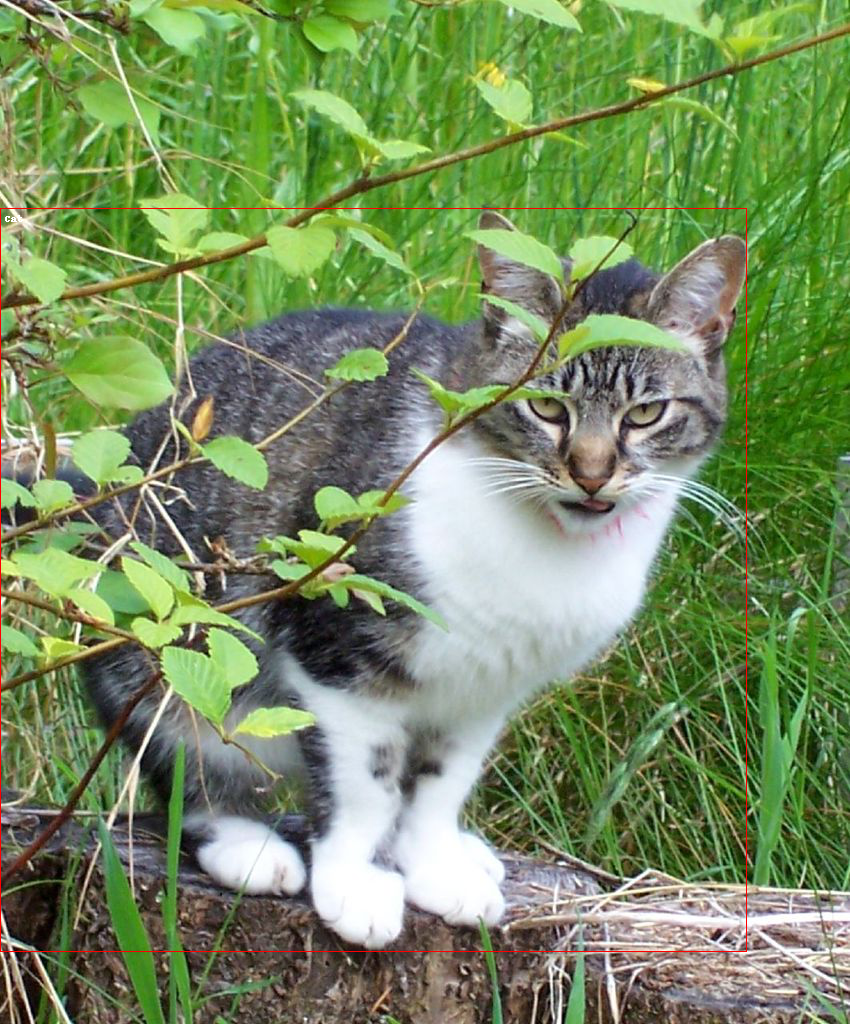

In [16]:
source_img, img_annots = dataset[13]
draw = ImageDraw.Draw(source_img)
for i in range(len(img_annots["boxes"])):
    x1, y1, x2, y2 = img_annots["boxes"][i]
    label = int(img_annots["labels"][i])

    draw.rectangle(((x1, y1), (x2, y2)), outline="red")
    text = f'{dataset.cat2name[label]}'
    draw.text((x1+5, y1+5), text)
display(source_img)

## Visualization of results

Now that training has finished, let's have a look at what it actually predicts.

In [17]:
# pick one image from the validation set
img, _ = val_dataset[13]

model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])

prediction

NameError: ignored

Printing the prediction shows that we have a list of dictionaries. Each element of the list corresponds to a different image. As we have a single image, there is a single dictionary in the list.
The dictionary contains the predictions for the image we passed. In this case, we can see that it contains `boxes`, `labels`, and `scores` as fields.

Let's inspect the image and the predicted boxes.
For that, we need to convert the image, which has been rescaled to 0-1 and had the channels flipped so that we have it in `[C, H, W]` format.

In [18]:
# convert the image, which has been rescaled to 0-1 and had the channels flipped
pred_img = Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())
draw = ImageDraw.Draw(pred_img)

img_preds = prediction[0]
for i in range(len(img_preds["boxes"])):
    x1, y1, x2, y2 = img_preds["boxes"][i]
    label = int(img_preds["labels"][i])
    score = float(img_preds["scores"][i])

    draw.rectangle(((x1, y1), (x2, y2)), outline="red")
    text = f'{dataset.cat2name[label]}: {score}'
    draw.text((x1+5, y1+5), text)

display(pred_img)

NameError: ignored

In [19]:
img_preds = prediction[0]
keep_idx = batched_nms(boxes=img_preds["boxes"], scores=img_preds["scores"], idxs=img_preds["labels"], iou_threshold=params['IOU_THRESHOLD'])

NameError: ignored

Load Model Weights


In [20]:
# hyper-parameters
params = {'BATCH_SIZE': 20,
          'LR': 0.005,
          'CLASSES': 6,
          'MAXEPOCHS': 20,
          'BACKBONE': 'resnet101',
          'FPN': True,
          'ANCHOR_SIZE': ((32,), (64,), (128,), (256,), (512,)),
          'ASPECT_RATIOS': ((0.5, 1.0, 2.0),),
          'MIN_SIZE': 512,
          'MAX_SIZE': 512,
          'IMG_MEAN': [0.485, 0.456, 0.406],
          'IMG_STD': [0.229, 0.224, 0.225],
          'IOU_THRESHOLD': 0.5
          }

In [21]:
def get_resnet_backbone(backbone_name: str):
    """
    Returns a resnet backbone pretrained on ImageNet.
    Removes the average-pooling layer and the linear layer at the end.
    """
    if backbone_name == 'resnet18':
        pretrained_model = models.resnet18(pretrained=True, progress=False)
        out_channels = 512
    elif backbone_name == 'resnet34':
        pretrained_model = models.resnet34(pretrained=True, progress=False)
        out_channels = 512
    elif backbone_name == 'resnet50':
        pretrained_model = models.resnet50(pretrained=True, progress=False)
        out_channels = 2048
    elif backbone_name == 'resnet101':
        pretrained_model = models.resnet101(pretrained=True, progress=False)
        out_channels = 2048
    elif backbone_name == 'resnet152':
        pretrained_model = models.resnet152(pretrained=True, progress=False)
        out_channels = 2048

    backbone = torch.nn.Sequential(*list(pretrained_model.children())[:-2])
    backbone.out_channels = out_channels

    return backbone

In [22]:
def get_resnet_fpn_backbone(backbone_name: str):
    """
    Returns a specified ResNet backbone with FPN pretrained on ImageNet.
    """
    return resnet_fpn_backbone(backbone_name, pretrained=True, trainable_layers=3)

In [23]:
def get_anchor_generator(anchor_size: Tuple[tuple] = None, aspect_ratios: Tuple[tuple] = None):
    """Returns the anchor generator."""
    if anchor_size is None:
        anchor_size = ((16,), (32,), (64,), (128,))
    if aspect_ratios is None:
        aspect_ratios = ((0.5, 1.0, 2.0),) * len(anchor_size)

    anchor_generator = AnchorGenerator(sizes=anchor_size,
                                       aspect_ratios=aspect_ratios)
    return anchor_generator

In [24]:
def get_roi_pool(featmap_names: List[str] = None, output_size: int = 7, sampling_ratio: int = 2):
    """Returns the ROI Pooling"""
    if featmap_names is None:
        # default for resnet with FPN
        featmap_names = ['0', '1', '2', '3']

    roi_pooler = MultiScaleRoIAlign(featmap_names=featmap_names,
                                    output_size=output_size,
                                    sampling_ratio=sampling_ratio)

    return roi_pooler

In [25]:
def get_fasterRCNN(backbone: torch.nn.Module,
                   anchor_generator: AnchorGenerator,
                   roi_pooler: MultiScaleRoIAlign,
                   num_classes: int,
                   image_mean: List[float] = [0.485, 0.456, 0.406],
                   image_std: List[float] = [0.229, 0.224, 0.225],
                   min_size: int = 512,
                   max_size: int = 1024,
                   **kwargs
                   ):
    """Returns the Faster-RCNN model. Default normalization: ImageNet"""
    model = FasterRCNN(backbone=backbone,
                       rpn_anchor_generator=anchor_generator,
                       box_roi_pool=roi_pooler,
                       num_classes=num_classes,
                       image_mean=image_mean,  # ImageNet
                       image_std=image_std,  # ImageNet
                       min_size=min_size,
                       max_size=max_size,
                       **kwargs
                       )
    model.num_classes = num_classes
    model.image_mean = image_mean
    model.image_std = image_std
    model.min_size = min_size
    model.max_size = max_size

    return model

In [26]:
def get_fasterRCNN_resnet(num_classes: int,
                          backbone_name: str,
                          anchor_size: List[float],
                          aspect_ratios: List[float],
                          fpn: bool = True,
                          min_size: int = 512,
                          max_size: int = 1024,
                          **kwargs
                          ):
    """Returns the Faster-RCNN model with resnet backbone with and without fpn."""

    # Backbone
    if fpn:
        backbone = get_resnet_fpn_backbone(backbone_name=backbone_name)
    else:
        backbone = get_resnet_backbone(backbone_name=backbone_name)

    # Anchors
    anchor_size = anchor_size
    aspect_ratios = aspect_ratios * len(anchor_size)
    anchor_generator = get_anchor_generator(anchor_size=anchor_size, aspect_ratios=aspect_ratios)

    # ROI Pool
    with torch.no_grad():
        backbone.eval()
        random_input = torch.rand(size=(1, 3, 512, 512))
        features = backbone(random_input)

    if isinstance(features, torch.Tensor):
        from collections import OrderedDict

        features = OrderedDict([('0', features)])

    featmap_names = [key for key in features.keys() if key.isnumeric()]

    roi_pool = get_roi_pool(featmap_names=featmap_names)

    # Model
    return get_fasterRCNN(backbone=backbone,
                          anchor_generator=anchor_generator,
                          roi_pooler=roi_pool,
                          num_classes=num_classes,
                          min_size=min_size,
                          max_size=max_size,
                          **kwargs)


In [46]:
model = get_fasterRCNN_resnet(num_classes=params['CLASSES'],
                              backbone_name=params['BACKBONE'],
                              anchor_size=params['ANCHOR_SIZE'],
                              aspect_ratios=params['ASPECT_RATIOS'],
                              fpn=params['FPN'],
                              min_size=params['MIN_SIZE'],
                              max_size=params['MAX_SIZE'],
                              image_mean=params['IMG_MEAN'],
                              image_std=params['IMG_STD'])

In [59]:
# load model weights
loadfilename = "c1_weights_"+str(params['BACKBONE'])+"_epochs_"+str(params['MAXEPOCHS'])+"_batchsize_"+str(params['BATCH_SIZE'])+".pth"
load_path = os.path.join(base_folder, loadfilename)
model.load_state_dict(torch.load(load_path))
model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(512,), max_size=512, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu)

In [60]:
# move model to the right device
model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(512,), max_size=512, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu)

In [61]:
# construct an optimizer
model_params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(model_params, 
                            lr=params['LR'],
                            momentum=0.9, 
                            weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

## Evaluation on Validation Set

As a sanity check, let's evaluate the model performance on the validation set

In [62]:
with open(val_annotation) as json_file:
    val_data = json.load(json_file)

model.eval()
detections = []
with torch.no_grad():
    for image in val_data["images"]:
        img_name = image["file_name"]
        img_id = image["id"]

        img = Image.open(os.path.join(til_root, 'images', img_name)).convert('RGB')
        img_tensor = transforms.ToTensor()(img)

        preds = model([img_tensor.to(device)])[0]

        for i in range(len(preds["boxes"])):
            x1, y1, x2, y2 = preds["boxes"][i]
            label = int(preds["labels"][i])
            score = float(preds["scores"][i])

            left = int(x1)
            top = int(y1)
            width = int(x2 - x1)
            height = int(y2 - y1)

            detections.append({'image_id':img_id, 'category_id':label, 'bbox':[left, top, width, height], 'score':score})

In [63]:
filepath = "validation_preds_"+str(params['BACKBONE'])+"_epochs_"+str(params['MAXEPOCHS'])+"_batchsize_"+str(params['BATCH_SIZE'])+".json"
validation_json = os.path.join(base_folder, filepath)
with open(validation_json, 'w') as f:
    json.dump(detections, f)

In [64]:
# Get evaluation score against validation set to make sure your prediction json file is in the correct format
coco_gt = COCO(val_annotation)
coco_dt = coco_gt.loadRes(validation_json)
cocoEval = COCOeval(cocoGt=coco_gt, cocoDt=coco_dt, iouType='bbox')
cocoEval.evaluate()
cocoEval.accumulate()
cocoEval.summarize()

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.35s).
Accumulating evaluation results...
DONE (t=0.08s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.626
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.884
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.707
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.424
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.634
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.601
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.723
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDet

## Generate Predictions on Test Images

In [65]:
# You should already have uploaded the testing images onto your google drive.

testing_images_path = os.path.join(base_folder, "c1_test_release.zip") # change this path to the zip file for the test images
!unzip $testing_images_path

Archive:  /content/drive/MyDrive/TIL2021_CV/c1_test_release.zip
replace c1_test_release/c1_test_sample.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: a
error:  invalid response [a]
replace c1_test_release/c1_test_sample.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: c1_test_release/c1_test_sample.json  
  inflating: c1_test_release/CREDITS.txt  
  inflating: c1_test_release/images/232.jpg  
  inflating: c1_test_release/images/181.jpg  
  inflating: c1_test_release/images/135.jpg  
  inflating: c1_test_release/images/236.jpg  
  inflating: c1_test_release/images/195.jpg  
  inflating: c1_test_release/images/101.jpg  
  inflating: c1_test_release/images/95.jpg  
  inflating: c1_test_release/images/93.jpg  
  inflating: c1_test_release/images/2.jpg  
  inflating: c1_test_release/images/59.jpg  
  inflating: c1_test_release/images/180.jpg  
  inflating: c1_test_release/images/65.jpg  
  inflating: c1_test_release/images/183.jpg  
  inflating: c1_test_release/images/62.jpg  
  infl

In [66]:
til_test_root = "/content/c1_test_release/" # extracted testing images path
test_img_root = os.path.join(til_test_root, "images")
img_dir = os.scandir(test_img_root)

Let's visualize some predictions on the test images. Run this a few times to visualize different images.

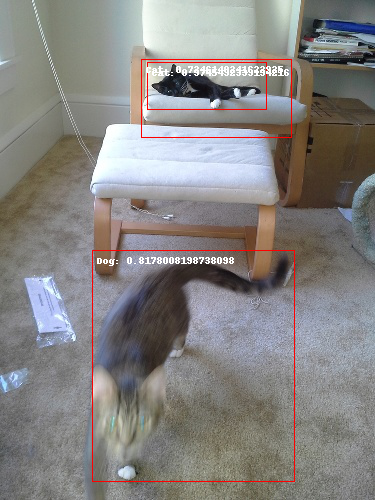

In [67]:
img = Image.open(next(img_dir).path).convert('RGB')
draw = ImageDraw.Draw(img)
det_threshold = 0.5

# do the prediction
with torch.no_grad():
    img_tensor = transforms.ToTensor()(img)
    img_preds = model([img_tensor.to(device)])[0]

for i in range(len(img_preds["boxes"])):
    x1, y1, x2, y2 = img_preds["boxes"][i]
    label = int(img_preds["labels"][i])
    score = float(img_preds["scores"][i])

    # filter out non-confident detections
    if score > det_threshold:
        draw.rectangle(((x1, y1), (x2, y2)), outline="red")
        text = f'{dataset.cat2name[label]}: {score}'
        draw.text((x1+5, y1+5), text)

display(img)

## Submission of Results

Submission json file should be in [COCO format](https://cocodataset.org/#format-results).

```
[{
    "image_id": int, 
    "category_id": int, 
    "bbox": [x,y,width,height], 
    "score": float,
}]
```

Refer to **sample_submission_cv.json** for an example.

For this competition, the metric for evaluation will be mAP @ 0.50:0.95

In [68]:
# generate detections on the folder of test images (this will be used for submission)
detections = []
with torch.no_grad():
    for image in img_dir:
        img_id = int(image.name.split('.')[0])

        img = Image.open(image.path).convert('RGB')
        img_tensor = transforms.ToTensor()(img)

        preds = model([img_tensor.to(device)])[0]

        for i in range(len(preds["boxes"])):
            x1, y1, x2, y2 = preds["boxes"][i]
            label = int(preds["labels"][i])
            score = float(preds["scores"][i])

            left = int(x1)
            top = int(y1)
            width = int(x2 - x1)
            height = int(y2 - y1)

            detections.append({'image_id':img_id, 'category_id':label, 'bbox':[left, top, width, height], 'score':score})

In [69]:

savefilename = "test_preds_"+str(params['BACKBONE'])+"_epochs_"+str(params['MAXEPOCHS'])+"_batchsize_"+str(params['BATCH_SIZE'])+".json"

test_pred_json = os.path.join(base_folder, savefilename)
with open(test_pred_json, 'w') as f:
    json.dump(detections, f)

## Check Your Submission JSON Format (RUN THIS BEFORE SUBMISSION)

Run this function first with the given sample json (change this path for the different challenges) to make sure everything works before you submit. Just need to ensure that there are no errors when you run this. **If you get any errors, check your generated json file.**

In [70]:
sample_json_path = os.path.join(til_test_root, "c1_test_sample.json")

coco_gt = COCO(sample_json_path)
coco_dt = coco_gt.loadRes(test_pred_json)
cocoEval = COCOeval(cocoGt=coco_gt, cocoDt=coco_dt, iouType='bbox')
cocoEval.evaluate()
cocoEval.accumulate()
cocoEval.summarize()

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.10s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDe

If you get an `AssertionError: Results do not correspond to current coco set`, it most likely means that some of the "image_id" are out of range (either 0 or higher than number of test images).